## AGRR: Automatic Gapping Resolution for Russian


#### 1. Подготовка данных (2 балла)
Скачайте данные (train, dev, test). Для работы с таблицей используйте pandas. 
Посчитайте, сколько в каждом из файлов примеров из класса 0 и из класса 1.

In [35]:
import pandas as pd 
import csv 
from string import punctuation
from collections import Iterable
from sklearn.linear_model import Perceptron
from pymystem3 import Mystem
import gensim
from gensim.models import KeyedVectors
import numpy as np

m = Mystem()
punct = punctuation + '«»—…“”""*–'

In [36]:
train = pd.read_csv('train.csv',sep = '\t', quoting=csv.QUOTE_NONE)
dev = pd.read_csv('dev.csv',sep = '\t', quoting=csv.QUOTE_NONE)
test = pd.read_csv('test.csv',sep = '\t', quoting=csv.QUOTE_NONE)

In [8]:
print("train: ")
print(train["class"].value_counts())

train: 
0    10864
1     5542
Name: class, dtype: int64


In [10]:
print("dev: ")
print(dev["class"].value_counts())

dev: 
0    2760
1    1382
Name: class, dtype: int64


In [11]:
print("test: ")
print(test["class"].value_counts())

test: 
0    1365
1     680
Name: class, dtype: int64


In [49]:
# объединим train и dev, будем тренировать на обоих
train = pd.concat([train, dev], axis=0, ignore_index=True)
train["class"].value_counts()

0    16384
1     8302
Name: class, dtype: int64

#### 2. Анализ разметки (2 балла)
Функция ниже преобразует оффсеты в колонках в числа и подсчитывает всевозможные сочетания оффсетов в датафрейме. 

In [51]:
def getOffsetVariants(df_):
    
    df = df_.loc[df_['class'] == 1]
    df.fillna(0, inplace = True)
    
    cV = []
    cR1 = []
    cR2 = []
    V = []
    R1 = []
    R2 = []
    
    for i in df.index:
        cV.append(len(str(df["cV"][i]).split(" "))) if df["cV"][i] != 0 else cV.append(0)
        cR1.append(len(str(df["cR1"][i]).split(" "))) if df["cR1"][i] != 0 else cR1.append(0)
        cR2.append(len(str(df["cR2"][i]).split(" "))) if df["cR2"][i] != 0 else cR2.append(0)
        V.append(len(str(df["V"][i]).split(" "))) if df["V"][i] != 0 else V.append(0)
        R1.append(len(str(df["R1"][i]).split(" "))) if df["R1"][i] != 0 else R1.append(0)
        R2.append(len(str(df["R2"][i]).split(" "))) if df["R2"][i] != 0 else R2.append(0)
        
    assert len(cV) == len(cR1) == len(cR2) == len(V) == len(R1) == len(R2)
    if not len(cV) == len(cR1) == len(cR2) == len(V) == len(R1) == len(R2):
        raise AssertionError()
        
    df_cols = ['cV','cR1', 'cR2', 'V', 'R1', 'R2']
    
    table = pd.DataFrame({"cV": cV,
                          "cR1": cR1,
                          "cR2": cR2,
                          "V": V, 
                          "R1": R1,  
                          "R2": R2},  columns=df_cols)
    
    return table.groupby(df_cols).size()

In [52]:
getOffsetVariants(train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


cV  cR1  cR2  V  R1  R2
1   0    1    1  1   1        1
    1    0    1  1   0      131
         1    1  1   1     7621
              2  2   2      461
              3  3   3       63
              4  4   4       21
              5  5   5        2
              7  7   7        2
dtype: int64

In [53]:
getOffsetVariants(test)

cV  cR1  cR2  V  R1  R2
1   1    0    1  1   0      16
              2  2   0       1
         1    1  1   1     616
              2  2   2      42
              3  3   3       3
              4  4   4       1
              5  5   5       1
dtype: int64

Мы видим, что чаще всего в предложениях встречается один оффсет для каждой метки, но есть достаточно много предложений с двумя и более оффсетами для некоторых меток (V, R1, R2). Там, где нет метки R2 (=0), скорее всего эллипсис находится в конце предложения. 

#### 3. Конвертер разметки-1 (1 балл)

Я выбрала IOB-разметку. Эта функция далась мне тяжело (заняла много времени), во-первых, из-за иногда неправильно отмеченных оффсетов в датасете, и, во-вторых, из-за ситуаций, когда между двумя словами, разделенными тире или дефисом, не было пробела. Мой код ниже неплохо справляется с данной задачей, но, к сожалению, уже ближе к дедлайну я обнаружила, что число тегов не всегда соответствует числу слов в очищенном от пунктуации предложении. Пришлось пожертвовать примерно 200-ми предложениями, чтобы подготовить данные для RNN без ошибок. Функция ниже. 
(Обратно из разметки можно перевести, используя индекс предложения). 

P.S. Буду благодарна, если в комментариях к домашней работе будут советы по более оптимальному решению, учитывающему все нюансы.  

In [61]:
def tokenize(sent): # функция токенизирует предложение и очищает от пунктуации
    sent = sent.replace(",", ", ")
    words = [word.rstrip(punct) for word in sent.split() if word.rstrip(punct)]
    return words

def flatten(list_): # функция делает из списков со вложенными списками список с одним уровнем вложенности
     for item in list_:
        if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                    yield x
        else:        
             yield item

def get_offsets(df, sent_indx, column_name): # функция извлекает слайсы предложений по оффсетам
    offsets = str(df[column_name][sent_indx]).split(" ")
    return [j.split(":") for j in offsets if offsets != ["nan"]]

def makeIOBtags(df): # непосредстенно сама функция разметки
     
    tagged_sents = {} # данные положим в словарь
    
    for indx in df.index:  
        if df["class"][indx] == 1:
            sent = df["text"][indx]
        
            cV = get_offsets(df, indx, "cV") # извлекаем слайсы
            cR1 = get_offsets(df, indx, "cR1")
            cR2 = get_offsets(df, indx, "cR2")
            R1 = get_offsets(df, indx, "R1")
            R2 = get_offsets(df, indx, "R2")
        
            cV_words = [sent[int(offset[0]):int(offset[1])] for offset in cV] # берем слова по слайсам согласно меткам
            cR1_words = [sent[int(offset[0]):int(offset[1])] for offset in cR1]
            cR2_words = [sent[int(offset[0]):int(offset[1])] for offset in cR2]
            R1_words = [sent[int(offset[0]):int(offset[1])] for offset in R1]
            R2_words = [sent[int(offset[0]):int(offset[1])] for offset in R2]
        
            for i, chunk in enumerate(cV_words):
                sent = sent.replace(chunk, " cV" + "_" + str(i)) # заменяем слайсы предложений метками и номером оффсета
            for i, chunk in enumerate(cR1_words):
                sent = sent.replace(chunk, " cR1" + "_" + str(i))
            for i, chunk in enumerate(cR2_words):
                sent = sent.replace(chunk, " cR2" + "_" + str(i))
            for i, chunk in enumerate(R1_words):
                sent = sent.replace(chunk, " R1" + "_" + str(i))
            for i, chunk in enumerate(R2_words):
                sent = sent.replace(chunk, " R2" + "_" + str(i))
                        
            t_sent = tokenize(sent) # токенизируем предложение
            labels = ("cV", "cR1", "cR2", "R1", "R2")          
            try:
                for i, word in enumerate(t_sent): # для каждой метки добавляем IOB-теги
                    if not word.startswith(labels):
                        t_sent[i] = "O"
                    elif word.startswith("cV"):
                        tokenized_cV_words = [tokenize(i) for i in cV_words]
                        chunk_number = int(word.split("_")[1][0]) # учитываем номер оффсета, чтобы не ошибиться с числом слов в нем
                        chunk_length = len(tokenized_cV_words[chunk_number])
                        if chunk_length == 1:
                            t_sent[i] = "B-cV"
                        elif chunk_length > 1:
                            t_sent[i] = (["B-cV"] + ["I-cV" for i in range(chunk_length-1)])
                    elif word.startswith("cR1"):
                        tokenized_cR1_words = [tokenize(i) for i in cR1_words]
                        chunk_number = int(word.split("_")[1][0])
                        chunk_length = len(tokenized_cR1_words[chunk_number])
                        if chunk_length == 1:
                            t_sent[i] = "B-cR1"
                        elif chunk_length > 1:
                            t_sent[i] = (["B-cR1"] + ["I-cR1" for i in range(chunk_length-1)])
                    elif word.startswith("cR2"):
                        tokenized_cR2_words = [tokenize(i) for i in cR2_words]
                        chunk_number = int(word.split("_")[1][0])
                        chunk_length = len(tokenized_cR2_words[chunk_number])
                        if chunk_length == 1:
                            t_sent[i] = "B-cR2"
                        elif chunk_length > 1:
                            t_sent[i] = (["B-cR2"] + ["I-cR2" for i in range(chunk_length-1)])
                    elif word.startswith("R1"):
                        tokenized_R1_words = [tokenize(i) for i in R1_words]
                        chunk_number = int(word.split("_")[1][0])
                        chunk_length = len(tokenized_R1_words[chunk_number])
                        if chunk_length == 1:
                            t_sent[i] = "B-R1"
                        elif chunk_length > 1:
                            t_sent[i] = (["B-R1"] + ["I-R1" for i in range(chunk_length-1)])
                    elif word.startswith("R2"):
                        tokenized_R2_words = [tokenize(i) for i in R2_words]
                        chunk_number = int(word.split("_")[1][0])
                        chunk_length = len(tokenized_R2_words[chunk_number])
                        if chunk_length == 1:
                            t_sent[i] = "B-R2"
                        elif chunk_length > 1:
                            t_sent[i] = (["B-R2"] + ["I-R2" for i in range(chunk_length-1)])
            except ValueError and IndexError:
                continue
            
            tags = list(flatten(t_sent)) # выравниваем список
            tagged_sents[indx] = tags # добавляем в словарь и сохраняем номер предложения
        
        elif df["class"][indx] == 0:  
            sent = train["text"][indx]
            sent_length = len(tokenize(sent))
            tags = ["O" for i in range(sent_length)]
            tagged_sents[indx] = tags
                        
    return tagged_sents

In [55]:
tags_for_train = makeIOBtags(train[:10])

In [60]:
print(tags_for_train[1], train.text[1], sep = "\n")

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-cR1', 'I-cR1', 'B-cV', 'O', 'B-cR2', 'O', 'O', 'B-R1', 'B-R2', 'I-R2']
Работа с двухбайтовыми наборами символов — просто кошмар для программиста, так как часть их состоит из одного байта, а часть — из двух.


#### 4. Конвертер разметки-2 (1 балл)

Простая и понятная функция. 

In [63]:
def offsets2brackets(df):
    sents = {}
    for indx in df.index:  
        if df["class"][indx] == 1:
            sent = df["text"][indx]
            
            cV = get_offsets(df, indx, "cV")
            cR1 = get_offsets(df, indx, "cR1")
            cR2 = get_offsets(df, indx, "cR2")
            V = get_offsets(df, indx, "V") # не забываем про сам эллипсис
            R1 = get_offsets(df, indx, "R1")
            R2 = get_offsets(df, indx, "R2")
            
            cV_words = [sent[int(offset[0]):int(offset[1])] for offset in cV]
            cR1_words = [sent[int(offset[0]):int(offset[1])] for offset in cR1]
            cR2_words = [sent[int(offset[0]):int(offset[1])] for offset in cR2]
            R1_words = [sent[int(offset[0]):int(offset[1])] for offset in R1]
            R2_words = [sent[int(offset[0]):int(offset[1])] for offset in R2]
            
            for offset in V:
                sent = sent[:int(offset[0])] + "V[] " + sent[int(offset[0]):]
             
            for chunk in cV_words:
                new_chunk = "cV[ " + chunk + " cV]"
                sent = sent.replace(chunk, new_chunk)
                
            for chunk in cR1_words:
                new_chunk = "cR1[ " + chunk + " cR1]"
                sent = sent.replace(chunk, new_chunk)
                
            for chunk in cR2_words:
                new_chunk = "cR2[ " + chunk + " cR2]"
                sent = sent.replace(chunk, new_chunk)
            
            for chunk in R1_words:
                new_chunk = "R1[ " + chunk + " R1]"
                sent = sent.replace(chunk, new_chunk)
            
            for chunk in R2_words:
                new_chunk = "R2[ " + chunk + " R2]"
                sent = sent.replace(chunk, new_chunk)
                            
            sents[indx] = sent
            
    return sents
            
sents = offsets2brackets(train[156:157])

In [64]:
sents[156]

'cR1[ Я cR1] и так этого года cV[ ждала cV] наверное cR2[ 9 cR2] лет а R1[ мама R1] V[] R2[ 11 R2].'

#### 5. Бинарная классификация (6 баллов (+2))
Постройте простую полносвязную сеть, берущую на вход все предложение и на выходе предсказывающую наличие или отсутствие гэппинга в предложении. Признаки: использование эмбеддингов +1 балл, использование pos-тэгов +1 балл. 

##### В данном задании я много экспериментировала, в итоге остановилась на конфигурации многослойного перцептрона на keras. Использовала и эмбеддинги, и POS-теги. 

Представим предложения в виде векторов с эмбеддингами и частями речи для каждого слова. Для начала лемматизируем и соберем частеречные теги. 

### 5.1 лемматизируем данные и получим POS-теги

In [66]:
def analyzeWithPunct(sents): # лемматизируем с сохранением пунктуации
    all_lemmas = []
    all_tags = []
    for sent in sents:
        analysis = m.analyze(sent)
        lemmas = []
        tags = []
        for word in analysis:
            try:
                pos = word["analysis"][0]["gr"].split(",")[0].split("=")[0]
                lemma = word["analysis"][0]["lex"]
                tags.append(pos)
                lemmas.append(lemma)
            except:
                symbol = word["text"]
                if symbol not in " \n": 
                    lemma = symbol.strip() # сохраняем пунктуацию (и другой шум) как отдельный токен
                    if symbol.strip() == ",":
                        pos = "COMMA"
                    elif symbol.strip() in "—-":
                        pos = "DASH"
                    else:
                        pos = "PUNCT"
                    tags.append(pos) 
                    lemmas.append(lemma)
        all_lemmas.append(lemmas)
        all_tags.append(tags)
    return all_lemmas, all_tags

In [68]:
train_lemmas, train_pos = analyzeWithPunct([i for i in train.text])

In [69]:
print(train_lemmas[1], train_pos[1])

['работа', 'с', 'двухбайтовый', 'набор', 'символ', '—', 'просто', 'кошмар', 'для', 'программист', ',', 'так', 'как', 'часть', 'они', 'состоять', 'из', 'один', 'байт', ',', 'а', 'часть', '—', 'из', 'два', '.'] ['S', 'PR', 'A', 'S', 'S', 'DASH', 'PART', 'S', 'PR', 'S', 'COMMA', 'ADVPRO', 'ADVPRO', 'S', 'SPRO', 'V', 'PR', 'ANUM', 'S', 'COMMA', 'CONJ', 'S', 'DASH', 'PR', 'NUM', 'PUNCT']


In [71]:
test_lemmas, test_pos = analyzeWithPunct([i for i in test.text])

### 5.2 Чтобы создать входной вектор определенной длины, узнаем максимальное число слов в предложениях train и test

In [324]:
lemmas = train_lemmas + test_lemmas
len_ = 0
counter = 0
for i in lemmas:
    counter += 1
    len_ += len(i)
avr_len = len_/counter 
print(avr_len)

19.8590401983354


Итак, средняя длина предложений - 20. Мы будем считать, что в среднем предложении 25 слов. 

### 5.3 Нормализуем POS-теги и преобразуем в one-hot вектора

In [73]:
# создадим словарь, который нормализует число POS-тегов до 25 на предложение 
# если в предложени более 25 слов, оно обрезается сначала, так как эллипсис чаще встречается в конце предложения
# также данная функция приводит теги Mystem к более общему виду: например, прилагательное-числительное у нас будет просто прилагательным
def tag2vec(tags_list):
    dictionary = {"V":"VERB", "S":"NOUN", "SPRO":"NOUN", "A":"ADJ", "ANUM":"ADJ", "APRO":"ADJ", 
                  "ADV":"ADV", "ADVPRO":"ADV", "CONJ":"CONJ", "PR":"PR", "PART":"PART", "INTJ":"INTJ", 
                  "NUM":"NUM", "COM":"COM", "COMMA":"COMMA", "DASH":"DASH", "PUNCT":"PUNCT"}
    tags_vec = [[dictionary[tag] for tag in sent] for sent in tags_list]
    for i, vec in enumerate(tags_vec):
        if len(vec) > 25:
            tags_vec[i] = vec[len(vec) - 25 : ]
        elif len(vec) < 25:
            tags_vec[i] = vec + ["0" for i in range(25 - len(vec))]
    return tags_vec

train_tags_vec = tag2vec(train_pos)
test_tags_vec = tag2vec(test_pos)

In [74]:
print(train_tags_vec[8]) # получается вот так

['ADJ', 'NOUN', 'VERB', 'VERB', 'PUNCT', 'NOUN', 'NOUN', 'PUNCT', 'NOUN', 'NOUN', 'COMMA', 'CONJ', 'ADJ', 'PUNCT', 'PUNCT', 'NOUN', 'ADJ', 'NOUN', 'PUNCT', '0', '0', '0', '0', '0', '0']


In [78]:
# переведем  pos-теги в one-hot вектора
pos_list = ["VERB", "NOUN", "ADJ", "ADV", "CONJ", "PR", "PART", "INTJ", "NUM", "COM", "COMMA", "DASH", "PUNCT"]
pos_list = pd.DataFrame(pos_list)
pos_list[0]

0      VERB
1      NOUN
2       ADJ
3       ADV
4      CONJ
5        PR
6      PART
7      INTJ
8       NUM
9       COM
10    COMMA
11     DASH
12    PUNCT
Name: 0, dtype: object

In [80]:
one_hot_pos = pd.get_dummies(pos_list[0])
one_hot_pos["0"] = [0 for i in range(13)]
one_hot_pos

,ADJ,ADV,COM,COMMA,CONJ,DASH,INTJ,NOUN,NUM,PART,PR,PUNCT,VERB,0
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [392]:
test_tags_vec = [[one_hot_pos[i].tolist() for i in tags] for tags in test_tags_vec]
train_tags_vec = [[one_hot_pos[i].tolist() for i in tags] for tags in train_tags_vec]

### 5.4 Эмбеддинги и окончательные вектора признаков
Я беру эмбеддинги из модели fastText, предобученной на собранном мной корпусе статей Новой газеты за 2015-2018 годы из рублик "Культура" и "Общество". Обучение велось на леммах (4325550 токенов)), без предлогов, местоимений и других стоп-слов. Размерность эмбеддингов в моей модели - 50.  

In [31]:
from gensim.models.fasttext import FastText
model2 = FastText.load_fasttext_format('fasttext/model.bin')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  


In [76]:
# функция объединяет признаки слов для предложения

def get_vector(sent, tags, model):
    matrix = np.zeros((25,50+13)) # размерность вектора предложения = 1575 (50 - эмбеддинг, 13 - POS-tag)
    if len(sent) > 25:
        sent = sent[len(sent) - 25 : ]
    for i, lemma in enumerate(sent):
        if lemma in model2.wv:
            vec = np.append(model2.wv[lemma], tags[i]) # эмбеддинг и POS-тег для каждого слова
            matrix[i] = vec
        else:
            pass
    vector = np.concatenate(matrix)
    return vector 

In [444]:
train_vec = [] # получаем вектора для train
for i in range(len(train_lemmas)):
    sent_vec = get_vector(train_lemmas[i], train_tags_vec[i], model2)
    train_vec.append(sent_vec)

In [371]:
test_vec = [] # получаем вектора для test
for i in range(len(test_lemmas)):
    sent_vec = get_vector(test_lemmas[i], test_tags_vec[i], model2)
    test_vec.append(sent_vec)

In [44]:
train_labels = [train_set["class"][i] for i in train_set.index] # и классы
test_labels = [test["class"][i] for i in test.index]

In [77]:
# Данные для модели почти готовы!

### 5.5 Модель на Keras

In [469]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras_metrics as km

In [470]:
x_train = np.stack(train_vec, axis=0) # преобразуем данные так, чтобы Keras прочел
x_test = np.stack(test_vec, axis=0)
y_train = np.asarray(train_labels)
y_test = np.asarray(test_labels)

In [516]:
# проектируем модель

model = Sequential([
    Dense(300, input_dim=1575), # на вход идет вектор размерностью 1575 (т.е. 50+13 (эмбеддинг + pos-тег на слово) * 25)
    Activation('relu'), # 3 скрытых слоя
    Dropout(0.5),
    Dense(200),
    Activation("relu"),
    Dropout(0.5),
    Dense(1),
    Activation('sigmoid') 
])

model.summary()

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_195 (Dense)            (None, 300)               472800    
_________________________________________________________________
activation_195 (Activation)  (None, 300)               0         
_________________________________________________________________
dropout_114 (Dropout)        (None, 300)               0         
_________________________________________________________________
dense_196 (Dense)            (None, 200)               60200     
_________________________________________________________________
activation_196 (Activation)  (None, 200)               0         
_________________________________________________________________
dropout_115 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_197 (Dense)            (None, 1)               

In [544]:
# компилируем модель. В качестве оптимизатора используем Adam 
# и в качестве функции потерь - кроссэнтропию для бинарной классификации

model.compile( 
 optimizer = "adam",
 loss = "binary_crossentropy", 
 metrics = [km.binary_precision(), km.binary_recall()]
)

results = model.fit(
    x_train, y_train,
    epochs = 5, # вроде бы 5 эпох достаточно
    batch_size = 50,
    validation_data = (x_test, y_test), # валидируем на тесте для удобства
    class_weight = {0:1., 1:2.} # балансируем классы
)

Train on 20543 samples, validate on 2045 samples
Epoch 1/5
20543/20543 [==============================] - 8s 393us/step - loss: 0.0775 - precision: 0.9616 - recall: 0.9785 - val_loss: 0.8116 - val_precision: 0.6546 - val_recall: 0.7721
Epoch 2/5
20543/20543 [==============================] - 8s 403us/step - loss: 0.0795 - precision: 0.9660 - recall: 0.9763 - val_loss: 0.8654 - val_precision: 0.6335 - val_recall: 0.8059
Epoch 3/5
20543/20543 [==============================] - 8s 396us/step - loss: 0.0740 - precision: 0.9632 - recall: 0.9760 - val_loss: 0.8809 - val_precision: 0.6453 - val_recall: 0.7706
Epoch 4/5
20543/20543 [==============================] - 8s 383us/step - loss: 0.0714 - precision: 0.9693 - recall: 0.9767 - val_loss: 0.8746 - val_precision: 0.6514 - val_recall: 0.7750
Epoch 5/5
20543/20543 [==============================] - 8s 371us/step - loss: 0.0707 - precision: 0.9682 - recall: 0.9764 - val_loss: 0.9692 - val_precision: 0.6349 - val_recall: 0.8029


In [547]:
score = model.evaluate(x_test, y_test)
score[1] * score[2] * 2 / (score[1] + score[2])
# получаем такую F-меру 

0.7090909089988193

#### 6. Оценка результатов бинарной классификации (1 балл)

In [576]:
predictions = model.predict_classes(x_test) # предсказываем
predictions[:5]

array([[0],
       [1],
       [0],
       [0],
       [0]], dtype=int32)

In [573]:
pred_df = pd.DataFrame([test.text[i] for i in test.index], columns = ["text"])

In [574]:
pred_df["class"] = predictions # размечаем

In [575]:
pred_df.head()

,text,class
0,Изобретение относится к судостроению и касаетс...,0
1,"Эти состояния называют фазами воды, а превраще...",1
2,И должен ни единой долькой Не отступаться от ...,0
3,Он потребовал обеспечить полное осуществление ...,0
4,"По мнению местного пастора Элла Эбанкса, запре...",0


In [578]:
pred_df.to_csv("output.csv", sep="\t", index=False)

Скрипт agrr_metrics.py выдал следующую оценку:
````
Binary classification quality (f1-score): 0.7131258457374832
Other metrics: 
 Precision: 0.6604010025062657
 Recall: 0.775
````

F-мера составила 0.71. Надеюсь, это неплохой результат, учитывая то, что это обычная сеть, и то, что здесь не использовался синтаксис в качестве признаков.  

#### 7. Классификация последовательности (7 баллов) 

Для начала напишем функцию, которая преобразует слова в предложениях в индексы из словаря, а IOB-теги - в one-hot вектора. Впоследствии нейронная сеть сделает из индексов слов эмбеддинги.

In [286]:
max_len = 60 # пока возьмем максимальную длину предложений, равную 60


def prepareXY(df): # функция принимает на вход весь датафрейм
    IOB_tags = makeIOBtags(df) # сделаем разметку по IOB-тегам для каждого предложения
    
    for indx in df.index:
        if indx not in IOB_tags.keys():
            df = df[df.index != indx] # поскольку эта разметка не идеальна (в том числе из-за самих данных)
                                      # удаляем из датафрейма предложения, которые не разметились
                                      # (в тесте все размечается хорошо, в трейне - нет)
    
    to_delete = []
    counter = 0
    for i in df:
        try:
            if len(df[i]) != len(tokenize(df.text[i])):  # или разметились неправильно (число тегов не равно числу токенов в предложении)
                counter += 1
                df = df[df.index != i]
                to_delete.append(i)
        except KeyError:
            continue
    for i in to_delete:
        del IOB_tags[i]
    
    df["IOB"] = [v for v in IOB_tags.values()] 
    print(df["class"].value_counts()) # после всех преобразований в датафрейме останется столько предложений
    
    sents = [tokenize(df.text[i]) for i in df.index] 
    for i, sent in enumerate(sents): # обрежем начало предложений у тех, в которых число слов > 60. 
        if len(sent) > max_len:
            sents[i] = sent[len(sent) - max_len : ]
    tags = [df.IOB[i] for i in df.index] 
    for i, sent_tags in enumerate(tags):  # и обрежем теги
        if len(sent_tags) > 60:
            tags[i] = sent_tags[len(sent_tags) - max_len : ]
    
    sent_tuples = []
    for i in range(len(sents)):
        sent_tuples.append([(w, t) for w, t in zip(sents[i], tags[i])])
    
    words = list(set(list(flatten(sents)))) # создадим словарь из токенов
    words.append("ENDPAD") # добавим тег, который будет заполнять пустое место в предложениях, где число слов < 60
    print(str(len(words)) + " words")
    tags = list(set(list(flatten(tags))))
    
    word2idx = {w: i for i, w in enumerate(words)}  
    tag2idx = {t: i for i, t in enumerate(tags)}
        
    X = [[word2idx[w[0]] for w in s] for s in sent_tuples] # закодируем слова в числа в предложениях
    X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=len(words) - 1) # сделаем паддинг
    Y = [[tag2idx[w[1]] for w in s] for s in sent_tuples] # закодируем IOB-теги в числа в предложениях
    Y = pad_sequences(maxlen=max_len, sequences=Y, padding="post", value=tag2idx["O"])
    Y = [to_categorical(i, num_classes=len(tag2idx)) for i in Y] # преобразуем их в one-hot вектора

    return X, Y, words, tags, df

In [287]:
train_X, train_Y, train_words, train_tags, train = prepareXY(train) # готовим данные для трейна

0    13624
1     6920
Name: class, dtype: int64
90251 words


In [289]:
test_X, test_Y, test_words, test_tags, test = prepareXY(test) # и для теста

0    1365
1     680
Name: class, dtype: int64
17570 words


In [290]:
train_X[1]

array([14813, 63305, 38148, 18497, 75263, 79443, 47497, 61148,   735,
       70585, 40939, 42421, 53807, 41264, 54837,  8735,  2495, 78535,
       42421, 54837, 42215, 90250, 90250, 90250, 90250, 90250, 90250,
       90250, 90250, 90250, 90250, 90250, 90250, 90250, 90250, 90250,
       90250, 90250, 90250, 90250, 90250, 90250, 90250, 90250, 90250,
       90250, 90250, 90250, 90250, 90250, 90250, 90250, 90250, 90250,
       90250, 90250, 90250, 90250, 90250, 90250], dtype=int32)

In [291]:
train_Y[1]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.,

Напишем модель на keras, двустороннюю LSTM, которая будет преобразовывать слова в эмбеддинги и запоминать их последовательности

In [175]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [176]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=len(words), output_dim=50, input_length=max_len)(input) 
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(len(tags), activation="softmax"))(model)  # softmax output layer

In [188]:
model = Model(input, out)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
# в качестве оптимизатора применим RMSProp — root mean square propagation
history = model.fit(train_X, np.array(train_Y), batch_size=32, epochs=10, validation_split=0.1, verbose=1)
# будем обучать на 10 эпохах

Train on 18301 samples, validate on 2034 samples
Epoch 1/10
18301/18301 [==============================] - 141s 8ms/step - loss: 0.0451 - acc: 0.9856 - val_loss: 0.2534 - val_acc: 0.9245
Epoch 2/10
18301/18301 [==============================] - 113s 6ms/step - loss: 0.0397 - acc: 0.9873 - val_loss: 0.2901 - val_acc: 0.9133
Epoch 3/10
18301/18301 [==============================] - 112s 6ms/step - loss: 0.0346 - acc: 0.9890 - val_loss: 0.2930 - val_acc: 0.9150
Epoch 4/10
18301/18301 [==============================] - 114s 6ms/step - loss: 0.0309 - acc: 0.9903 - val_loss: 0.2763 - val_acc: 0.9219
Epoch 5/10
18301/18301 [==============================] - 113s 6ms/step - loss: 0.0276 - acc: 0.9913 - val_loss: 0.3205 - val_acc: 0.9115
Epoch 6/10
18301/18301 [==============================] - 114s 6ms/step - loss: 0.0246 - acc: 0.9922 - val_loss: 0.3333 - val_acc: 0.9089
Epoch 7/10
18301/18301 [==============================] - 111s 6ms/step - loss: 0.0223 - acc: 0.9929 - val_loss: 0.3428 - v

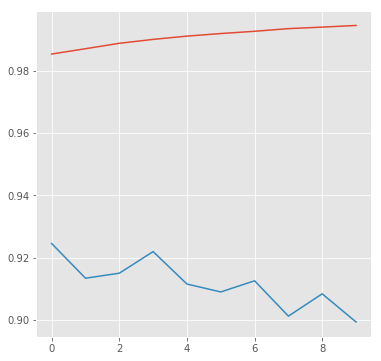

In [189]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(6,6))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

Странно, что в первую эпоху на валидации результаты получились лучше. Возможно, что это из-за специфики примеров. В целом точность неплохая. 

### Теперь сделаем предсказания

In [257]:
all_output_tags = []
all_output_words = []
for i in test.index:
    p = model.predict(np.array([test_X[i]]))
    p = np.argmax(p, axis=-1)
    sent_words = []
    sent_tags = []
    for w, pred in zip(test_X[i], p[0]):
        if test_words[w] != "ENDPAD":
            sent_words.append(test_words[w])
            sent_tags.append(test_tags[pred])
    all_output_words.append(sent_words)
    all_output_tags.append(sent_tags)

In [260]:
print(all_output_words[2])

['И', 'должен', 'ни', 'единой', 'долькой', 'Не', 'отступаться', 'от', 'лица', 'Но', 'быть', 'живым', 'живым', 'и', 'только', 'Живым', 'и', 'только', 'до', 'конца']


In [261]:
print(all_output_tags[2])

['O', 'B-cV', 'O', 'O', 'O', 'O', 'B-cR1', 'B-cR1', 'I-cR1', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


#### 8. Оценка результатов полной разметки (1 балл)
Обученной сеткой разметьте тестовые данные, с помощью готового скрипта agrr_metrics.py оцените полученный результат.
Пример вызова из командной строки:
> python3 agrr_metrics.py test.csv output.csv

#### 9. Анализ результатов (до 4 баллов)
Проведите анализ ошибок. Посмотрите на fn, fp примеры, приведите несколько таких предложений в скобочной записи (если вы решали задачу классификации последовательности). Можно ли попытаться обобщить получаемые ошибки?

to be continued... 